In [1]:
import random

import findspark
findspark.init()
import pyspark

from pyspark.ml.feature import VectorAssembler, StringIndexer, OneHotEncoder, Bucketizer
from pyspark.ml.regression import LinearRegression
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.sql.session import SparkSession
from pyspark.sql.types import *
from pyspark.sql.functions import isnan, when, count, col, abs
from pyspark.sql import functions as sf 

In [2]:
filename = "2004.csv"

In [3]:
def _init_spark():
    spark = SparkSession.builder.appName("Project").getOrCreate()
    sc = spark.sparkContext
    return spark, sc

spark, sc = _init_spark()
sqlContext = SQLContext(sc)

df = sqlContext.read.load(filename, 
                      format='com.databricks.spark.csv', 
                      header='true',
                      delimiter=',',
                      inferSchema='true')
df.cache()

col_to_drop = ['ArrTime', 'ActualElapsedTime', 'AirTime', 'TaxiIn', 'Diverted',
               'CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay', 
               'Year', 'TailNum', 'CancellationCode' ] # Only those 3 I added up to delay, others 
                                                       # are delayed as is stated in the task
df = df.drop(*col_to_drop)
df = df.withColumn("ArrDelay", df["ArrDelay"].cast(IntegerType()))
df = df.withColumn("DepDelay", df["DepDelay"].cast(IntegerType()))
df = df.withColumn("CRSDepTime", df["CRSDepTime"].cast(IntegerType()))
df = df.withColumn("CRSArrTime", df["CRSArrTime"].cast(IntegerType()))
df = df.withColumn("DepTime", df["DepTime"].cast(IntegerType()))

df = df.filter("Cancelled == 0") #select only those flights that happened
df = df.drop("Cancelled")
df = df.drop(*["UniqueCarrier", "DayofMonth", "FlightNum"]) #Droping unimportant categorical variables

df = df.na.drop("any") # Drop columns with null values +- 99% of dataset remains 

In [4]:
df.show(5) 

+-----+---------+-------+----------+----------+--------------+--------+--------+------+----+--------+-------+
|Month|DayOfWeek|DepTime|CRSDepTime|CRSArrTime|CRSElapsedTime|ArrDelay|DepDelay|Origin|Dest|Distance|TaxiOut|
+-----+---------+-------+----------+----------+--------------+--------+--------+------+----+--------+-------+
|    1|        1|    623|       630|       915|           105|     -14|      -7|   ORD| CLT|     599|     11|
|    1|        2|    621|       630|       915|           105|      -4|      -9|   ORD| CLT|     599|     16|
|    1|        3|    633|       630|       915|           105|       5|       3|   ORD| CLT|     599|     15|
|    1|        4|    627|       630|       915|           105|     -16|      -3|   ORD| CLT|     599|     10|
|    1|        5|    635|       630|       915|           105|       3|       5|   ORD| CLT|     599|     13|
+-----+---------+-------+----------+----------+--------------+--------+--------+------+----+--------+-------+
only showi

In [5]:
# Introducing interaction between the categorical variables: Origin and Dest

In [6]:
df = df.withColumn('OrigDest', 
                    sf.concat(sf.col('Origin'),sf.lit('_'), sf.col('Dest')))
df = df.drop(*["Origin", "Dest"])

In [7]:
df.show(1)

+-----+---------+-------+----------+----------+--------------+--------+--------+--------+-------+--------+
|Month|DayOfWeek|DepTime|CRSDepTime|CRSArrTime|CRSElapsedTime|ArrDelay|DepDelay|Distance|TaxiOut|OrigDest|
+-----+---------+-------+----------+----------+--------------+--------+--------+--------+-------+--------+
|    1|        1|    623|       630|       915|           105|     -14|      -7|     599|     11| ORD_CLT|
+-----+---------+-------+----------+----------+--------------+--------+--------+--------+-------+--------+
only showing top 1 row



In [8]:
# Converting continuous to categorical:, "DepTime" "CRSDepTime", "CRSArrTime" which are times. 
# We want to seperate them to types of the day (morning, aftenoon, evening, night): https://www.learnersdictionary.com/qa/parts-of-the-day-early-morning-late-morning-etc

In [9]:
splits = [-float("inf"), 500, 1200, 1700, float("inf")]
bucketizer = Bucketizer(splitsArray= [splits, splits, splits], inputCols=["CRSDepTime", "CRSArrTime", "DepTime"], outputCols=["CatCRSDepTime", "CatCRSArrTime", "CatDepTime"])
df = bucketizer.transform(df)

df = df.drop(*["CRSDepTime", "CRSArrTime"])

In [10]:
varIdxer = StringIndexer(inputCol="OrigDest",outputCol="IndOrigDest").fit(df)
df = varIdxer.transform(df)
df = df.drop("OrigDest")

In [11]:
df.show(5)

+-----+---------+-------+--------------+--------+--------+--------+-------+-------------+-------------+----------+-----------+
|Month|DayOfWeek|DepTime|CRSElapsedTime|ArrDelay|DepDelay|Distance|TaxiOut|CatCRSDepTime|CatCRSArrTime|CatDepTime|IndOrigDest|
+-----+---------+-------+--------------+--------+--------+--------+-------+-------------+-------------+----------+-----------+
|    1|        1|    623|           105|     -14|      -7|     599|     11|          1.0|          1.0|       1.0|      178.0|
|    1|        2|    621|           105|      -4|      -9|     599|     16|          1.0|          1.0|       1.0|      178.0|
|    1|        3|    633|           105|       5|       3|     599|     15|          1.0|          1.0|       1.0|      178.0|
|    1|        4|    627|           105|     -16|      -3|     599|     10|          1.0|          1.0|       1.0|      178.0|
|    1|        5|    635|           105|       3|       5|     599|     13|          1.0|          1.0|       1

In [12]:
# One Hot encoding the categorical data:

In [13]:
oneHot = OneHotEncoder(inputCols=['Month', 'DayOfWeek', 'CatCRSDepTime', 'CatCRSArrTime', 'IndOrigDest', 'CatDepTime'],
                       outputCols=['HotMonth', 'HotDayOfWeek', 'HotCRSCatDepTime', 'HotCRSCatArrTime', 'HotIndOrigDest', 'HotDepTime']).fit(df)
df = oneHot.transform(df)
df = df.drop(*['Month', 'DayOfWeek', 'CatDepTime', 'CatCRSDepTime', 'CatCRSArrTime', 'IndOrigDest'])

In [14]:
df.show(5)

+-------+--------------+--------+--------+--------+-------+------------------+--------------+----------------+----------------+-------------+-------------+
|DepTime|CRSElapsedTime|ArrDelay|DepDelay|Distance|TaxiOut|    HotIndOrigDest|      HotMonth|HotCRSCatDepTime|HotCRSCatArrTime| HotDayOfWeek|   HotDepTime|
+-------+--------------+--------+--------+--------+-------+------------------+--------------+----------------+----------------+-------------+-------------+
|    623|           105|     -14|      -7|     599|     11|(4408,[178],[1.0])|(12,[1],[1.0])|   (3,[1],[1.0])|   (3,[1],[1.0])|(7,[1],[1.0])|(3,[1],[1.0])|
|    621|           105|      -4|      -9|     599|     16|(4408,[178],[1.0])|(12,[1],[1.0])|   (3,[1],[1.0])|   (3,[1],[1.0])|(7,[2],[1.0])|(3,[1],[1.0])|
|    633|           105|       5|       3|     599|     15|(4408,[178],[1.0])|(12,[1],[1.0])|   (3,[1],[1.0])|   (3,[1],[1.0])|(7,[3],[1.0])|(3,[1],[1.0])|
|    627|           105|     -16|      -3|     599|     10|(4408

In [15]:
df = df.withColumn("Speed", sf.round(col("Distance") / col("CRSElapsedTime"), 2))
df = df.drop(*["Distance", "CRSElapsedTime"])

In [16]:
df.show(5)

+-------+--------+--------+-------+------------------+--------------+----------------+----------------+-------------+-------------+-----+
|DepTime|ArrDelay|DepDelay|TaxiOut|    HotIndOrigDest|      HotMonth|HotCRSCatDepTime|HotCRSCatArrTime| HotDayOfWeek|   HotDepTime|Speed|
+-------+--------+--------+-------+------------------+--------------+----------------+----------------+-------------+-------------+-----+
|    623|     -14|      -7|     11|(4408,[178],[1.0])|(12,[1],[1.0])|   (3,[1],[1.0])|   (3,[1],[1.0])|(7,[1],[1.0])|(3,[1],[1.0])|  5.7|
|    621|      -4|      -9|     16|(4408,[178],[1.0])|(12,[1],[1.0])|   (3,[1],[1.0])|   (3,[1],[1.0])|(7,[2],[1.0])|(3,[1],[1.0])|  5.7|
|    633|       5|       3|     15|(4408,[178],[1.0])|(12,[1],[1.0])|   (3,[1],[1.0])|   (3,[1],[1.0])|(7,[3],[1.0])|(3,[1],[1.0])|  5.7|
|    627|     -16|      -3|     10|(4408,[178],[1.0])|(12,[1],[1.0])|   (3,[1],[1.0])|   (3,[1],[1.0])|(7,[4],[1.0])|(3,[1],[1.0])|  5.7|
|    635|       3|       5|     13

In [17]:
# FINAL SELECTION:
X1 = ['DepDelay', 'TaxiOut']
X2 = ['DepDelay', 'TaxiOut',  'HotDepTime']
X3 = ['DepDelay', 'TaxiOut', 'HotIndOrigDest', 'HotDepTime'] 
X4 = ['DepDelay', 'TaxiOut', 'HotDayOfWeek', 'HotMonth', 'Speed'] 
X5 = ['DepDelay', 'TaxiOut', 'HotDayOfWeek', 'HotIndOrigDest', 'Speed']
X6 = ['DepDelay', 'TaxiOut', 'HotIndOrigDest', 'Speed', 'HotCRSCatDepTime', 'HotCRSCatArrTime', 'HotDepTime']

## General Linear model

In [18]:
assembler = VectorAssembler(inputCols=X1, outputCol='features')
output = assembler.transform(df).select('features', 'ArrDelay')
train, test = output.randomSplit([0.75, 0.25])

In [19]:
lin_reg = LinearRegression(featuresCol = 'features', labelCol='ArrDelay')
linear_model = lin_reg.fit(train)

#trainSummary = linear_model.summary
#print("RMSE: %f" % trainSummary.rootMeanSquaredError)
#print("MSE: %f" %  trainSummary.meanSquaredError)
#print("\nr2: %f" % trainSummary.r2)

In [20]:
predictions = linear_model.transform(test)
x =((predictions['ArrDelay']-predictions['prediction'])/predictions['ArrDelay'])*100
predictions = predictions.withColumn('Accuracy',abs(x))
#predictions.select("prediction","ArrDelay","Accuracy","features").show(10)

In [21]:
pred_evaluator = RegressionEvaluator(predictionCol="prediction",labelCol="ArrDelay",metricName="r2")
print("R Squared (R2) on test data = %g" % pred_evaluator.evaluate(predictions))

evaluator = RegressionEvaluator(labelCol='ArrDelay', predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % 3)

evaluator = RegressionEvaluator(labelCol='ArrDelay', predictionCol="prediction", metricName="mae"
mae = evaluator.evaluate(predictions)
print("Mean Absolute Error (MAE) on test data = %g" % mae)

R Squared (R2) on test data = 0.861688
Root Mean Squared Error (RMSE) on test data = 12.4481
Mean Absolute Error (MAE) on test data = 7.83326


## General Linear model with ParamGridBuilder and TrainValidationSplit

In [22]:
df = df.withColumnRenamed("ArrDelay", "label")

In [23]:
df.show(5)

+-------+-----+--------+-------+------------------+--------------+----------------+----------------+-------------+-------------+-----+
|DepTime|label|DepDelay|TaxiOut|    HotIndOrigDest|      HotMonth|HotCRSCatDepTime|HotCRSCatArrTime| HotDayOfWeek|   HotDepTime|Speed|
+-------+-----+--------+-------+------------------+--------------+----------------+----------------+-------------+-------------+-----+
|    623|  -14|      -7|     11|(4408,[178],[1.0])|(12,[1],[1.0])|   (3,[1],[1.0])|   (3,[1],[1.0])|(7,[1],[1.0])|(3,[1],[1.0])|  5.7|
|    621|   -4|      -9|     16|(4408,[178],[1.0])|(12,[1],[1.0])|   (3,[1],[1.0])|   (3,[1],[1.0])|(7,[2],[1.0])|(3,[1],[1.0])|  5.7|
|    633|    5|       3|     15|(4408,[178],[1.0])|(12,[1],[1.0])|   (3,[1],[1.0])|   (3,[1],[1.0])|(7,[3],[1.0])|(3,[1],[1.0])|  5.7|
|    627|  -16|      -3|     10|(4408,[178],[1.0])|(12,[1],[1.0])|   (3,[1],[1.0])|   (3,[1],[1.0])|(7,[4],[1.0])|(3,[1],[1.0])|  5.7|
|    635|    3|       5|     13|(4408,[178],[1.0])|(12,

In [24]:
assembler = VectorAssembler(inputCols=X1, outputCol='features')
output = assembler.transform(df).select('features','label')

In [25]:
train, test = output.randomSplit([0.75, 0.25])

In [26]:
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit


lin_reg = LinearRegression(featuresCol = 'features')


# We use a ParamGridBuilder and TrainValidationSplit to determin the best model

paramGrid = ParamGridBuilder()\
    .addGrid(lin_reg.regParam, [0.1, 0.05]) \
    .addGrid(lin_reg.fitIntercept, [False, True])\
    .addGrid(lin_reg.elasticNetParam, [0.0, 0.5, 1.0])\
    .addGrid(lin_reg.maxIter, [1, 3])\
    .build()

tvs = TrainValidationSplit(estimator=lin_reg,
                           estimatorParamMaps=paramGrid,
                           evaluator=RegressionEvaluator(),
                           trainRatio=0.75)

model = tvs.fit(train)


model.transform(test)\
    .select("features", "label", "prediction")\
    .show(5)

+---------+-----+-----------------+
| features|label|       prediction|
+---------+-----+-----------------+
|(2,[],[])|  -34|-8.10724902732001|
|(2,[],[])|  -23|-8.10724902732001|
|(2,[],[])|  -21|-8.10724902732001|
|(2,[],[])|  -19|-8.10724902732001|
|(2,[],[])|  -15|-8.10724902732001|
+---------+-----+-----------------+
only showing top 5 rows



In [27]:
predictions = model.transform(test)
x =((predictions['label']-predictions['prediction'])/predictions['label'])*100
predictions = predictions.withColumn('Accuracy',abs(x))
#predictions.select("prediction","ArrDelay","Accuracy","features").show(10)

In [28]:
pred_evaluator = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="label",metricName="r2")
print("R Squared (R2) on test data = %g" % pred_evaluator.evaluate(predictions))

evaluator = RegressionEvaluator(
    labelCol='label', predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

evaluator = RegressionEvaluator(
    labelCol='label', predictionCol="prediction", metricName="mae")
mae = evaluator.evaluate(predictions)
print("Mean Absolute Error (MAE) on test data = %g" % mae)

R Squared (R2) on test data = 0.86138
Root Mean Squared Error (RMSE) on test data = 12.3888
Mean Absolute Error (MAE) on test data = 7.84175


X1:
R Squared (R2) on test data = 0.826373
Root Mean Squared Error (RMSE) on test data = 13.8497
Mean Squared Error (RMSE) on test data = 191.815

X2:
R Squared (R2) on test data = 0.86015
Root Mean Squared Error (RMSE) on test data = 12.3931
Mean Squared Error (RMSE) on test data = 153.59

X2_DepTime
R Squared (R2) on test data = 0.86645
Root Mean Squared Error (RMSE) on test data = 12.2173
Mean Squared Error (RMSE) on test data = 149.264

X2_DepTimeCont
R Squared (R2) on test data = 0.865903
Root Mean Squared Error (RMSE) on test data = 12.217
Mean Squared Error (RMSE) on test data = 149.254

X3:
R Squared (R2) on test data = 0.867128
Root Mean Squared Error (RMSE) on test data = 12.1511
Mean Squared Error (RMSE) on test data = 147.649

X3_HotDepTime
R Squared (R2) on test data = 0.869852
Root Mean Squared Error (RMSE) on test data = 12.0166
Mean Squared Error (RMSE) on test data = 144.399

X4:
R Squared (R2) on test data = 0.859676
Root Mean Squared Error (RMSE) on test data = 12.5005
Mean Squared Error (RMSE) on test data = 156.263

X4_HotDepTime
R Squared (R2) on test data = 0.861924
Root Mean Squared Error (RMSE) on test data = 12.4194
Mean Squared Error (RMSE) on test data = 154.242

X5: 
R Squared (R2) on test data = 0.863975
Root Mean Squared Error (RMSE) on test data = 12.2739
Mean Squared Error (RMSE) on test data = 150.648

X5_HotDepTime
R Squared (R2) on test data = 0.873747
Root Mean Squared Error (RMSE) on test data = 11.8387
Mean Squared Error (RMSE) on test data = 140.154

X6:
R Squared (R2) on test data = 0.870854
Root Mean Squared Error (RMSE) on test data = 12.0075
Mean Squared Error (RMSE) on test data = 144.179

X6_NoWeekNoSpeed:
R Squared (R2) on test data = 0.869446
Root Mean Squared Error (RMSE) on test data = 12.0361
Mean Squared Error (RMSE) on test data = 144.868

X6_NoSpeed:
R Squared (R2) on test data = 0.8693
Root Mean Squared Error (RMSE) on test data = 12.0816
Mean Squared Error (RMSE) on test data = 145.966

X6_NoWeek:
R Squared (R2) on test data = 0.873866
Root Mean Squared Error (RMSE) on test data = 11.8401
Mean Squared Error (RMSE) on test data = 140.188

X6_NoWeek_DepTime
R Squared (R2) on test data = 0.878756
Root Mean Squared Error (RMSE) on test data = 11.6798
Mean Squared Error (RMSE) on test data = 136.418

X6_NoWeek_DepTimeCont
R Squared (R2) on test data = 0.872805
Root Mean Squared Error (RMSE) on test data = 11.9287
Mean Squared Error (RMSE) on test data = 142.295

In [29]:
sc.stop()

In [50]:

A = ['DepDelay', 'TaxiOut']

A=A+['CIAO']
print(A)          

['DepDelay', 'TaxiOut', 'CIAO']


In [47]:

LINEAR REGRESSION MODEL 

{'name': 'X1', 'variables': ['DepDelay', 'TaxiOut'], 'R2LR': 0.8571472396949983}
{'name': 'X2', 'variables': ['DepDelay', 'TaxiOut', 'HotDepTime'], 'R2LR': 0.8658256539987146}
{'name': 'X3', 'variables': ['DepDelay', 'TaxiOut', 'HotIndOrigDest', 'HotDepTime'], 'R2LR': 0.8591920095549392}
{'name': 'X4', 'variables': ['DepDelay', 'TaxiOut', 'HotDayOfWeek', 'HotMonth', 'Speed'], 'R2LR': 0.864338816570524}
{'name': 'X5', 'variables': ['DepDelay', 'TaxiOut', 'HotDayOfWeek', 'HotIndOrigDest', 'Speed'], 'R2LR': 0.861180514036612}
{'name': 'X6', 'variables': ['DepDelay', 'TaxiOut', 'HotIndOrigDest', 'Speed', 'HotCRSCatDepTime', 'HotCRSCatArrTime', 'HotDepTime'], 'R2LR': 0.8608941223250091}










{'name': 'X1', 'variables': ['DepDelay', 'TaxiOut'], 'nonon': 1}
{'name': 'X2', 'variables': ['DepDelay', 'TaxiOut', 'HotDepTime'], 'nonon': 1}
{'name': 'X3', 'variables': ['DepDelay', 'TaxiOut', 'HotIndOrigDest', 'HotDepTime'], 'nonon': 1}
{'name': 'X4', 'variables': ['DepDelay', 'TaxiOut', 'HotDayOfWeek', 'HotMonth', 'Speed'], 'nonon': 1}
{'name': 'X5', 'variables': ['DepDelay', 'TaxiOut', 'HotDayOfWeek', 'HotIndOrigDest', 'Speed'], 'nonon': 1}
{'name': 'X6', 'variables': ['DepDelay', 'TaxiOut', 'HotIndOrigDest', 'Speed', 'HotCRSCatDepTime', 'HotCRSCatArrTime', 'HotDepTime'], 'nonon': 1}


In [112]:
df = []
df.append({'name': 'X1', 'variables': ['DepDelay', 'TaxiOut'],'R2LR': 0.8634434987176677, 'maeLR': 7.846344636291409, 'rmseLR': 12.3050200542969, 'R2RF': 0.7113226179229843, 'maeRF': 9.632419894894845, 'rmseRF': 17.870397493687378, 'R2DT': 0.7395671668525245, 'maeDT': 9.286871202251607, 'rmseDT': 16.973667925546085, 'R2GBR': 0.6779749591610146, 'maeGBR': 10.291720285041185, 'rmseGBR': 18.93692861799665})
df.append({'name': 'X2', 'variables': ['DepDelay', 'TaxiOut', 'HotDepTime'], 'R2LR': 0.8583557878034125, 'maeLR': 7.867042776829008, 'rmseLR': 12.564304679339765, 'R2RF': 0.6618056282411904, 'maeRF': 10.69581629434264, 'rmseRF': 19.317928448876994, 'R2DT': 0.7359741049968364, 'maeDT': 9.276273778053989, 'rmseDT': 17.06870714215145, 'R2GBR': 0.7317420904346483, 'maeGBR': 8.919500016072934, 'rmseGBR': 17.40522038041701})
df.append({'name': 'X3', 'variables': ['DepDelay', 'TaxiOut', 'HotIndOrigDest', 'HotDepTime'], 'R2LR': 0.8593969897926946, 'maeLR': 7.864282380701789, 'rmseLR': 12.472191555732724, 'R2RF': 0.6893474138730874, 'maeRF': 10.391762216453797, 'rmseRF': 18.48095278940399, 'R2DT': 0.7429083054863235, 'maeDT': 9.244540689810753, 'rmseDT': 16.812445684525386, 'R2GBR': 0.7340066674151544, 'maeGBR': 8.970977217618819, 'rmseGBR': 17.224534616062524})
df.append({'name': 'X4', 'variables': ['DepDelay', 'TaxiOut', 'HotDayOfWeek', 'HotMonth', 'Speed'], 'R2LR': 0.863433896705197, 'maeLR': 7.857176780272817, 'rmseLR': 12.347649838818601, 'R2RF': 0.6473918259213414, 'maeRF': 10.698236247649278, 'rmseRF': 19.77355050663056, 'R2DT': 0.734263104956572, 'maeDT': 9.320667734524053, 'rmseDT': 17.16581381584866, 'R2GBR': 0.7466087502783435, 'maeGBR': 8.799469470636394, 'rmseGBR': 16.83094772729247})
df.append({'name': 'X5', 'variables': ['DepDelay', 'TaxiOut', 'HotDayOfWeek', 'HotIndOrigDest', 'Speed'], 'R2LR': 0.861890103017749, 'maeLR': 7.867812623708982, 'rmseLR': 12.361847068397935, 'R2RF': 0.6450061986902308, 'maeRF': 10.972519639797552, 'rmseRF': 19.980872071516536, 'R2DT': 0.7374275663556327, 'maeDT': 9.256949155299973, 'rmseDT': 17.184172320005104, 'R2GBR': 0.7402478789139912, 'maeGBR': 8.916626117462856, 'rmseGBR': 17.048795624738972})
df.append({'name': 'X6', 'variables': ['DepDelay', 'TaxiOut', 'HotIndOrigDest', 'Speed', 'HotCRSCatDepTime', 'HotCRSCatArrTime', 'HotDepTime'], 'R2LR': 0.857932175860417, 'maeLR': 7.869501841196455, 'rmseLR': 12.564909943926322, 'R2RF': 0.6932635305087731, 'maeRF': 10.377749609744654, 'rmseRF': 18.532997429411278, 'R2DT': 0.7426814121619514, 'maeDT': 9.235528412342111, 'rmseDT': 16.974560476441024, 'R2GBR': 0.7393962128806398, 'maeGBR': 8.897008426472556, 'rmseGBR': 16.96102270986277})
        
df

[{'name': 'X1',
  'variables': ['DepDelay', 'TaxiOut'],
  'R2LR': 0.8634434987176677,
  'maeLR': 7.846344636291409,
  'rmseLR': 12.3050200542969,
  'R2RF': 0.7113226179229843,
  'maeRF': 9.632419894894845,
  'rmseRF': 17.870397493687378,
  'R2DT': 0.7395671668525245,
  'maeDT': 9.286871202251607,
  'rmseDT': 16.973667925546085,
  'R2GBR': 0.6779749591610146,
  'maeGBR': 10.291720285041185,
  'rmseGBR': 18.93692861799665},
 {'name': 'X2',
  'variables': ['DepDelay', 'TaxiOut', 'HotDepTime'],
  'R2LR': 0.8583557878034125,
  'maeLR': 7.867042776829008,
  'rmseLR': 12.564304679339765,
  'R2RF': 0.6618056282411904,
  'maeRF': 10.69581629434264,
  'rmseRF': 19.317928448876994,
  'R2DT': 0.7359741049968364,
  'maeDT': 9.276273778053989,
  'rmseDT': 17.06870714215145,
  'R2GBR': 0.7317420904346483,
  'maeGBR': 8.919500016072934,
  'rmseGBR': 17.40522038041701},
 {'name': 'X3',
  'variables': ['DepDelay', 'TaxiOut', 'HotIndOrigDest', 'HotDepTime'],
  'R2LR': 0.8593969897926946,
  'maeLR': 7.864

In [2]:
import seaborn as sns


import seaborn as sns


#sax = sns.barplot(x="name", y="variables", hue="sex", data=df)

In [3]:
import pandas as pd


#df = []
#df.append({'name': 'X1', 'variables': ['DepDelay', 'TaxiOut'],'R2LR': 0.8634434987176677, 'maeLR': 7.846344636291409, 'rmseLR': 12.3050200542969, 'R2RF': 0.7113226179229843, 'maeRF': 9.632419894894845, 'rmseRF': 17.870397493687378, 'R2DT': 0.7395671668525245, 'maeDT': 9.286871202251607, 'rmseDT': 16.973667925546085, 'R2GBR': 0.6779749591610146, 'maeGBR': 10.291720285041185, 'rmseGBR': 18.93692861799665})
#df.append({'name': 'X2', 'variables': ['DepDelay', 'TaxiOut', 'HotDepTime'], 'R2LR': 0.8583557878034125, 'maeLR': 7.867042776829008, 'rmseLR': 12.564304679339765, 'R2RF': 0.6618056282411904, 'maeRF': 10.69581629434264, 'rmseRF': 19.317928448876994, 'R2DT': 0.7359741049968364, 'maeDT': 9.276273778053989, 'rmseDT': 17.06870714215145, 'R2GBR': 0.7317420904346483, 'maeGBR': 8.919500016072934, 'rmseGBR': 17.40522038041701})
#df.append({'name': 'X3', 'variables': ['DepDelay', 'TaxiOut', 'HotIndOrigDest', 'HotDepTime'], 'R2LR': 0.8593969897926946, 'maeLR': 7.864282380701789, 'rmseLR': 12.472191555732724, 'R2RF': 0.6893474138730874, 'maeRF': 10.391762216453797, 'rmseRF': 18.48095278940399, 'R2DT': 0.7429083054863235, 'maeDT': 9.244540689810753, 'rmseDT': 16.812445684525386, 'R2GBR': 0.7340066674151544, 'maeGBR': 8.970977217618819, 'rmseGBR': 17.224534616062524})
#df.append({'name': 'X4', 'variables': ['DepDelay', 'TaxiOut', 'HotDayOfWeek', 'HotMonth', 'Speed'], 'R2LR': 0.863433896705197, 'maeLR': 7.857176780272817, 'rmseLR': 12.347649838818601, 'R2RF': 0.6473918259213414, 'maeRF': 10.698236247649278, 'rmseRF': 19.77355050663056, 'R2DT': 0.734263104956572, 'maeDT': 9.320667734524053, 'rmseDT': 17.16581381584866, 'R2GBR': 0.7466087502783435, 'maeGBR': 8.799469470636394, 'rmseGBR': 16.83094772729247})
#df.append({'name': 'X5', 'variables': ['DepDelay', 'TaxiOut', 'HotDayOfWeek', 'HotIndOrigDest', 'Speed'], 'R2LR': 0.861890103017749, 'maeLR': 7.867812623708982, 'rmseLR': 12.361847068397935, 'R2RF': 0.6450061986902308, 'maeRF': 10.972519639797552, 'rmseRF': 19.980872071516536, 'R2DT': 0.7374275663556327, 'maeDT': 9.256949155299973, 'rmseDT': 17.184172320005104, 'R2GBR': 0.7402478789139912, 'maeGBR': 8.916626117462856, 'rmseGBR': 17.048795624738972})
#df.append({'name': 'X6', 'variables': ['DepDelay', 'TaxiOut', 'HotIndOrigDest', 'Speed', 'HotCRSCatDepTime', 'HotCRSCatArrTime', 'HotDepTime'], 'R2LR': 0.857932175860417, 'maeLR': 7.869501841196455, 'rmseLR': 12.564909943926322, 'R2RF': 0.6932635305087731, 'maeRF': 10.377749609744654, 'rmseRF': 18.532997429411278, 'R2DT': 0.7426814121619514, 'maeDT': 9.235528412342111, 'rmseDT': 16.974560476441024, 'R2GBR': 0.7393962128806398, 'maeGBR': 8.897008426472556, 'rmseGBR': 16.96102270986277})

#DF = pd.DataFrame(df)
#DF



df = []


df.append({'name': 'X1', 'variables': ['DepDelay', 'TaxiOut'], 'R2LR': 0.8487903355707609, 'maeLR': 8.254203949687557, 
           'rmseLR': 13.357852222696085, 'R2RF': 0.6759576608407803, 'maeRF': 9.558676440697752, 'rmseRF': 19.55454607694188,
           'R2DT': 0.8032666305931366, 'maeDT': 8.047167549349105, 'rmseDT': 15.236523113473122, 'R2GBR': 0.6649182404076608,
           'maeGBR': 9.675284505657434, 'rmseGBR': 19.884846986992816})
df.append({'name': 'X2', 'variables': ['DepDelay', 'TaxiOut', 'HotDepTime'], 'R2LR': 0.8489949458043238, 'maeLR': 8.252050205312143,
           'rmseLR': 13.348811535729615, 'R2RF': 0.644799691553426, 'maeRF': 10.410105159800944, 'rmseRF': 20.47309618941201,
           'R2DT': 0.7986591618729234, 'maeDT': 8.068663783415948, 'rmseDT':15.41390918299755, 'R2GBR': 0.6683870248902969,
           'maeGBR': 9.659422733445206, 'rmseGBR': 19.781654723979745})


df.append({'name': 'X3', 'variables': ['DepDelay', 'TaxiOut', 'HotDayOfWeek', 'Speed'], 'R2LR': 0.8453066720437468, 'maeLR': 8.516841091450017,
           'rmseLR': 13.510849337721847, 'R2RF': 0.6798746674350129, 'maeRF': 9.611946601913983, 'rmseRF': 19.435999584336425,
           'R2DT': 0.772726932457265, 'maeDT': 8.924279621965104,'rmseDT': 16.376490840804454, 'R2GBR': 0.6662276903048072,
           'maeGBR': 9.517958778290287, 'rmseGBR': 19.8459554354681})
df.append({'name': 'X4', 'variables': ['DepDelay', 'TaxiOut', 'HotDayOfWeek', 'Speed', 'HotMonth'], 'R2LR': 0.8453066720437468,
           'maeLR': 8.516841091450017, 'rmseLR': 13.510849337721847, 'R2RF': 0.6583646385479186, 'maeRF': 10.150267901405842,
           'rmseRF': 20.07836144826715, 'R2DT': 0.772726932457265, 'maeDT': 8.924279621965104, 'rmseDT': 16.376490840804454,
           'R2GBR': 0.6662276903048072, 'maeGBR': 9.517958778290287, 'rmseGBR': 19.8459554354681})
df.append({'name': 'X5', 'variables': ['DepDelay', 'TaxiOut', 'Speed', 'HotDepTime', 'HotCRSCatDepTime', 'HotCRSCatArrTime'],
           'R2LR': 0.849299106562841, 'maeLR':8.236637503003521, 'rmseLR': 13.335360889080057, 'R2RF': 0.7422082226657248,
           'maeRF': 9.457975466805955, 'rmseRF': 17.441401922330556, 'R2DT': 0.8218174939776446, 'maeDT': 8.069864076215985,
           'rmseDT': 14.500380251761074, 'R2GBR': 0.7330045514728256, 'maeGBR': 9.248915319717614, 'rmseGBR': 17.750017631378764})

DF = pd.DataFrame(df)
DF

,name,variables,R2LR,maeLR,rmseLR,R2RF,maeRF,rmseRF,R2DT,maeDT,rmseDT,R2GBR,maeGBR,rmseGBR
0,X1,"[DepDelay, TaxiOut]",0.848790,8.254204,13.357852,0.675958,9.558676,19.554546,0.803267,8.047168,15.236523,0.664918,9.675285,19.884847
1,X2,"[DepDelay, TaxiOut, HotDepTime]",0.848995,8.252050,13.348812,0.644800,10.410105,20.473096,0.798659,8.068664,15.413909,0.668387,9.659423,19.781655
2,X3,"[DepDelay, TaxiOut, HotDayOfWeek, Speed]",0.845307,8.516841,13.510849,0.679875,9.611947,19.436000,0.772727,8.924280,16.376491,0.666228,9.517959,19.845955
3,X4,"[DepDelay, TaxiOut, HotDayOfWeek, Speed, HotMo...",0.845307,8.516841,13.510849,0.658365,10.150268,20.078361,0.772727,8.924280,16.376491,0.666228,9.517959,19.845955
4,X5,"[DepDelay, TaxiOut, Speed, HotDepTime, HotCRSC...",0.849299,8.236638,13.335361,0.742208,9.457975,17.441402,0.821817,8.069864,14.500380,0.733005,9.248915,17.750018


In [5]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns



df = []

df.append({'name': 'X1', 'variables': ['DepDelay', 'TaxiOut'], 'R2LR': 0.848790335569873, 'maeLR': 8.254203949649844, 'rmseLR': 13.357852222735302, 'R2RF': 0.7877559078906491,
           'maeRF': 8.690293592295992, 'rmseRF': 15.825763266816535, 'R2DT': 0.7059873772919286, 'maeDT': 9.159949932310596, 'rmseDT': 18.626439574457574, 'R2GBR': 0.7801504689193002,
           'maeGBR': 8.974679230672011, 'rmseGBR': 16.106813558025433})
df.append({'name': 'X2', 'variables': ['DepDelay', 'TaxiOut', 'HotDepTime'], 'R2LR': 0.8489788287666751, 'maeLR': 8.247368525825191, 'rmseLR': 13.349523887905121,
           'R2RF': 0.7080441813304268, 'maeRF': 10.099658590566785, 'rmseRF': 18.561173373506993, 'R2DT': 0.7077990453685918, 'maeDT': 9.156622344951545,
           'rmseDT': 18.568964032421498, 'R2GBR': 0.7829637568902307, 'maeGBR': 8.980932393113847, 'rmseGBR': 16.00342693486118})
df.append({'name': 'X3', 'variables': ['DepDelay', 'TaxiOut', 'HotDayOfWeek', 'Speed'], 'R2LR': 0.8489062083033445, 'maeLR': 8.251724318568577, 'rmseLR': 13.352733146869062,
           'R2RF': 0.7796457610596806, 'maeRF': 8.899327896668446, 'rmseRF': 16.125291139348988, 'R2DT': 0.6963053492718762, 'maeDT': 9.659059205591378,
           'rmseDT': 18.930645852632466, 'R2GBR': 0.7806196241471486, 'maeGBR': 8.982048579861763, 'rmseGBR': 16.089618544083184})
df.append({'name': 'X4', 'variables': ['DepDelay', 'TaxiOut', 'HotDayOfWeek', 'Speed', 'HotMonth'], 'R2LR': 0.8489062083033445, 'maeLR': 8.251724318568577, 'rmseLR': 13.352733146869062,
           'R2RF': 0.7594210857470316, 'maeRF': 9.317102724902446, 'rmseRF': 16.84905857345685, 'R2DT': 0.6963053492718762, 'maeDT': 9.659059205591378, 'rmseDT': 18.930645852632466,
           'R2GBR': 0.7806196241471486, 'maeGBR': 8.982048579861763, 'rmseGBR': 16.089618544083184})
df.append({'name': 'X5', 'variables': ['DepDelay', 'TaxiOut', 'Speed', 'HotDepTime', 'HotCRSCatArrTime'], 'R2LR': 0.8492324525435019, 'maeLR': 8.238176418842533,'rmseLR': 13.338309634506583,
           'R2RF': 0.7982677595565673, 'maeRF': 8.793428421143643, 'rmseRF': 15.428884064982618, 'R2DT': 0.7215302827888515, 'maeDT':9.057134404415605, 'rmseDT': 18.127413718161968,
           'R2GBR': 0.7849650085757035, 'maeGBR': 8.94831769579893, 'rmseGBR': 15.929473719628344})

DF = pd.DataFrame(df)
DF



,name,variables,R2LR,maeLR,rmseLR,R2RF,maeRF,rmseRF,R2DT,maeDT,rmseDT,R2GBR,maeGBR,rmseGBR
0,X1,"[DepDelay, TaxiOut]",0.848790,8.254204,13.357852,0.787756,8.690294,15.825763,0.705987,9.159950,18.626440,0.780150,8.974679,16.106814
1,X2,"[DepDelay, TaxiOut, HotDepTime]",0.848979,8.247369,13.349524,0.708044,10.099659,18.561173,0.707799,9.156622,18.568964,0.782964,8.980932,16.003427
2,X3,"[DepDelay, TaxiOut, HotDayOfWeek, Speed]",0.848906,8.251724,13.352733,0.779646,8.899328,16.125291,0.696305,9.659059,18.930646,0.780620,8.982049,16.089619
3,X4,"[DepDelay, TaxiOut, HotDayOfWeek, Speed, HotMo...",0.848906,8.251724,13.352733,0.759421,9.317103,16.849059,0.696305,9.659059,18.930646,0.780620,8.982049,16.089619
4,X5,"[DepDelay, TaxiOut, Speed, HotDepTime, HotCRSC...",0.849232,8.238176,13.338310,0.798268,8.793428,15.428884,0.721530,9.057134,18.127414,0.784965,8.948318,15.929474


[Text(0, 0.5, 'RMSE'), Text(0.5, 0, 'Variables')]

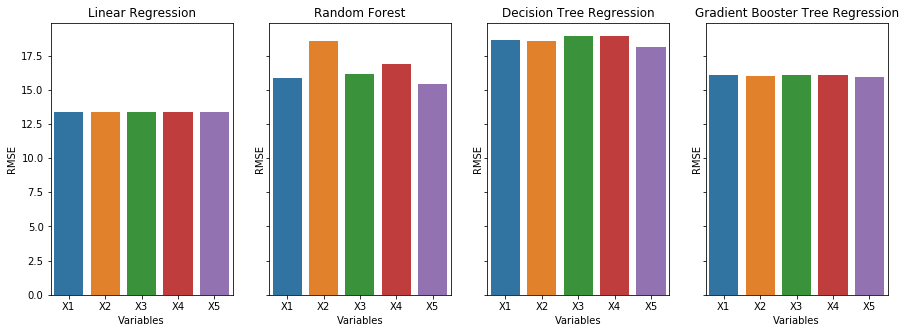

In [6]:
import matplotlib.pyplot as plt
#RMSE


fig, axes = plt.subplots(1, 4, figsize=(15, 5), sharey=True)
#fig.suptitle('Comparing R2 per each model')


sns.barplot(ax=axes[0], x=DF.name, y=DF.rmseLR)
axes[0].set_title('Linear Regression')
axes[0].set(xlabel='Variables', ylabel='RMSE')


sns.barplot(ax=axes[1], x=DF.name, y=DF.rmseRF)
axes[1].set_title('Random Forest')
axes[1].set(xlabel='Variables',ylabel='RMSE')


sns.barplot(ax=axes[2], x=DF.name, y=DF.rmseDT)
axes[2].set_title('Decision Tree Regression')
axes[2].set(xlabel='Variables',ylabel='RMSE')

sns.barplot(ax=axes[3], x=DF.name, y=DF.rmseGBR)
axes[3].set_title('Gradient Booster Tree Regression')
axes[3].set(xlabel='Variables',ylabel='RMSE')





[Text(0, 0.5, 'MAE'), Text(0.5, 0, 'Variables')]

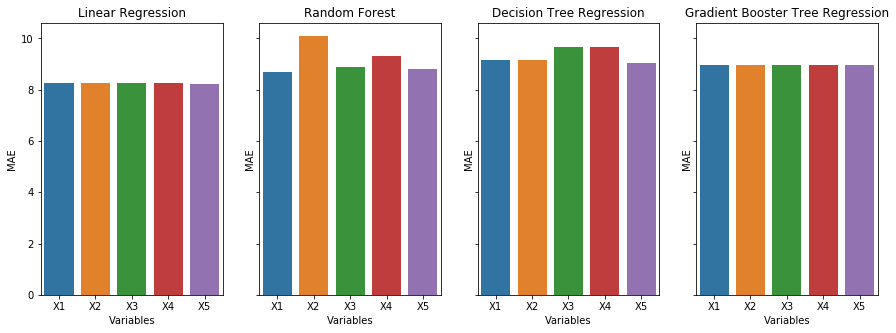

In [7]:

#MAE


fig, axes = plt.subplots(1, 4, figsize=(15, 5), sharey=True)
#fig.suptitle('Comparing R2 per each model')


sns.barplot(ax=axes[0], x=DF.name, y=DF.maeLR)
axes[0].set_title('Linear Regression')
axes[0].set(xlabel='Variables', ylabel='MAE')


sns.barplot(ax=axes[1], x=DF.name, y=DF.maeRF)
axes[1].set_title('Random Forest')
axes[1].set(xlabel='Variables',ylabel='MAE')


sns.barplot(ax=axes[2], x=DF.name, y=DF.maeDT)
axes[2].set_title('Decision Tree Regression')
axes[2].set(xlabel='Variables',ylabel='MAE')

sns.barplot(ax=axes[3], x=DF.name, y=DF.maeGBR)
axes[3].set_title('Gradient Booster Tree Regression')
axes[3].set(xlabel='Variables',ylabel='MAE')





[Text(0, 0.5, 'R2'), Text(0.5, 0, 'Variables')]

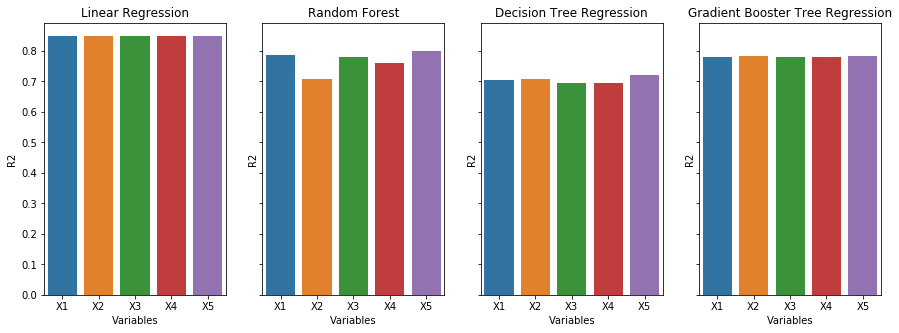

In [8]:

#R2


fig, axes = plt.subplots(1, 4, figsize=(15, 5), sharey=True)
#fig.suptitle('Comparing R2 per each model')


sns.barplot(ax=axes[0], x=DF.name, y=DF.R2LR)
axes[0].set_title('Linear Regression')
axes[0].set(xlabel='Variables', ylabel='R2')


sns.barplot(ax=axes[1], x=DF.name, y=DF.R2RF)
axes[1].set_title('Random Forest')
axes[1].set(xlabel='Variables',ylabel='R2')


sns.barplot(ax=axes[2], x=DF.name, y=DF.R2DT)
axes[2].set_title('Decision Tree Regression')
axes[2].set(xlabel='Variables',ylabel='R2')

sns.barplot(ax=axes[3], x=DF.name, y=DF.R2GBR)
axes[3].set_title('Gradient Booster Tree Regression')
axes[3].set(xlabel='Variables',ylabel='R2')


[Text(0, 0.5, 'R2'), Text(0.5, 0, 'Variables')]

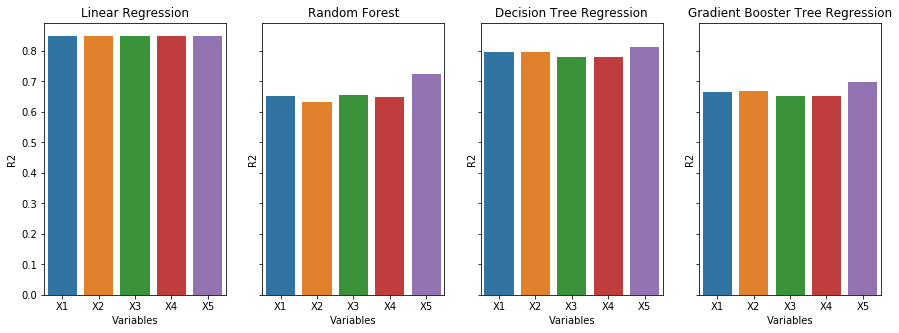

In [11]:

#R2


fig, axes = plt.subplots(1, 4, figsize=(15, 5), sharey=True)
#fig.suptitle('Comparing R2 per each model')


sns.barplot(ax=axes[0], x=DF.name, y=DF.R2LR)
axes[0].set_title('Linear Regression')
axes[0].set(xlabel='Variables', ylabel='R2')


sns.barplot(ax=axes[1], x=DF.name, y=DF.R2RF)
axes[1].set_title('Random Forest')
axes[1].set(xlabel='Variables',ylabel='R2')


sns.barplot(ax=axes[2], x=DF.name, y=DF.R2DT)
axes[2].set_title('Decision Tree Regression')
axes[2].set(xlabel='Variables',ylabel='R2')

sns.barplot(ax=axes[3], x=DF.name, y=DF.R2GBR)
axes[3].set_title('Gradient Booster Tree Regression')
axes[3].set(xlabel='Variables',ylabel='R2')




alt.Chart(...)